<a href="https://colab.research.google.com/github/christianadriano/PCA_AquacultureSystem/blob/master/PCA_KMeans_Environment_Piscicultura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd #tables for data wrangling
import numpy as np #basic statistical methods 
import io #for uploading data

#Manual option
from google.colab import files
uploaded = files.upload() #choose file dados_relativizados_centralizados_piscicultura.csv



Saving dados_relativizados_centralizados_piscicultura.csv to dados_relativizados_centralizados_piscicultura.csv


In [2]:
#Upload data from cvs file
df = pd.read_csv(io.StringIO(uploaded['dados_relativizados_centralizados_piscicultura.csv'].decode('utf-8'))) 
#print(df)

In [3]:
column_names = df.columns
#Select fatores Ambientais 
feature_names = [name for name in column_names if name.startswith("A")] 

#feature_names = list(df.columns["A2_DA":"A4_EUC"])
#print(feature_names)
list_names = ['cultivo'] + feature_names
df_cultivo = df[list_names]
df_cultivo.head()



,cultivo,A2_DA,A3_UE,A5_UN,A6_UF,A7_EUE,A8_EUN,A9_EUF,A12_PPO,A22_REC,A4_EUC
0,Truta - race-way,3.122172e+00,-0.557896,-0.561669,-0.197903,0.483326,1.267756,-0.227593,-1.335571e+00,-0.756929,-1.015822e+00
1,Tilapia - gaiolas - SP - sem restricao alimentar,1.410000e-10,1.955370,1.146380,-0.310220,1.961236,1.383958,2.095118,-9.420000e-11,-0.756929,1.597613e+00
2,Tilapia - gaiolas - SP - com restricao alimentar,1.410000e-10,2.316823,1.284580,-0.285437,2.219217,1.498797,2.158006,-9.420000e-11,-0.756929,2.078678e+00
3,Tilapia - gaiola - RS,3.775720e-01,-0.288911,2.504503,3.256382,-0.439364,-0.555705,0.129240,-9.420000e-11,-0.756929,3.150000e-16
4,Tambatinga - viveiro 2,-7.745291e-03,-0.547845,-0.551644,-0.334452,-0.696611,-1.312654,-0.710166,2.676561e+00,-0.621360,3.150000e-16


In [4]:
#Look at correlations 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

corr = df_cultivo.corr()

# using a styled panda's dataframe from https://stackoverflow.com/a/42323184/1215012
cmap = 'coolwarm'

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_precision(2)\



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,A2_DA,A3_UE,A5_UN,A6_UF,A7_EUE,A8_EUN,A9_EUF,A12_PPO,A22_REC,A4_EUC
A2_DA,1.00,0.01,0.09,0.16,0.25,0.35,0.10,-0.30,-0.49,-0.12
A3_UE,0.01,1.00,0.56,-0.05,0.89,0.58,0.95,0.00,-0.42,0.83
A5_UN,0.09,0.56,1.00,0.75,0.52,0.29,0.67,-0.01,-0.40,0.56
A6_UF,0.16,-0.05,0.75,1.00,-0.10,-0.15,0.08,-0.01,-0.27,0.03
A7_EUE,0.25,0.89,0.52,-0.10,1.00,0.80,0.95,-0.17,-0.31,0.77
A8_EUN,0.35,0.58,0.29,-0.15,0.80,1.00,0.69,-0.27,0.14,0.27
A9_EUF,0.10,0.95,0.67,0.08,0.95,0.69,1.00,-0.07,-0.37,0.83
A12_PPO,-0.30,0.00,-0.01,-0.01,-0.17,-0.27,-0.07,1.00,0.02,-0.03
A22_REC,-0.49,-0.42,-0.40,-0.27,-0.31,0.14,-0.37,0.02,1.00,-0.48
A4_EUC,-0.12,0.83,0.56,0.03,0.77,0.27,0.83,-0.03,-0.48,1.00


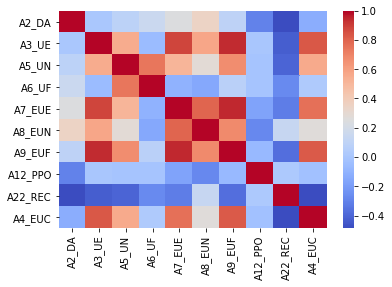

In [5]:
#smaller chart
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm')

In [6]:
#check which ones are statiscally significant
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

p_values = calculate_pvalues(df_cultivo)



In [7]:
#Plot p-values
def highlight_significant(val):
    '''
    highlight in blue only the statistically significant cells
    '''
    color = 'blue' if val < 0.05 else 'grey'
    return 'color: %s' % color

p_values.style.applymap(highlight_significant)

,A2_DA,A3_UE,A5_UN,A6_UF,A7_EUE,A8_EUN,A9_EUF,A12_PPO,A22_REC,A4_EUC
A2_DA,0.000000,0.977600,0.782300,0.625800,0.437400,0.261800,0.760700,0.351000,0.108700,0.699400
A3_UE,0.977600,0.000000,0.060800,0.871800,0.000100,0.049200,0.000000,0.994400,0.169300,0.000800
A5_UN,0.782300,0.060800,0.000000,0.005000,0.085700,0.361700,0.016800,0.984500,0.194300,0.057100
A6_UF,0.625800,0.871800,0.005000,0.000000,0.752700,0.643400,0.800200,0.975200,0.397500,0.920900
A7_EUE,0.437400,0.000100,0.085700,0.752700,0.000000,0.001900,0.000000,0.600500,0.320200,0.003600
A8_EUN,0.261800,0.049200,0.361700,0.643400,0.001900,0.000000,0.013700,0.392200,0.668800,0.388600
A9_EUF,0.760700,0.000000,0.016800,0.800200,0.000000,0.013700,0.000000,0.836200,0.242800,0.000800
A12_PPO,0.351000,0.994400,0.984500,0.975200,0.600500,0.392200,0.836200,0.000000,0.941500,0.936000
A22_REC,0.108700,0.169300,0.194300,0.397500,0.320200,0.668800,0.242800,0.941500,0.000000,0.113500
A4_EUC,0.699400,0.000800,0.057100,0.920900,0.003600,0.388600,0.000800,0.936000,0.113500,0.000000


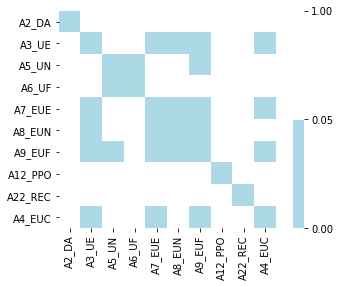

In [8]:
#Smaller plot of p-values
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

np.random.seed(101)
zvals = np.random.rand(100, 100) * 10

# make a color map of fixed colors
cmap_discrete = colors.ListedColormap(['lightblue', 'white'])
bounds=[0,0.05,1]
norm_binary = colors.BoundaryNorm(bounds, cmap_discrete.N)

# tell imshow about color map so that only set colors are used
img = plt.imshow(zvals, interpolation='nearest', origin='lower',
                    cmap=cmap_discrete, norm=norm_binary)

sns.heatmap(p_values, xticklabels=p_values.columns, yticklabels=p_values.columns, cmap=cmap_discrete, norm=norm_binary)

**PCA** 
Now we do the PCA 

In [9]:
#Normalize the data to have MEAN==0
from sklearn.preprocessing import StandardScaler

x = df_cultivo.iloc[:,1:].values
x = StandardScaler().fit_transform(x) # normalizing the features
#print(x)


In [10]:
#Run PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df_cultivo[['cultivo']]], axis = 1)

['Truta - race-way' 'Tilapia - gaiolas - SP -  sem restricao alimentar'
 'Tilapia - gaiolas - SP - com restricao alimentar'
 'Tilapia - gaiola - RS' 'Tambatinga - viveiro 2'
 'Tambatinga - viveiro 23' 'Tambatinga - viveiro 250'
 'Tambaqui - M amazonicum - policultivo - SP' 'Tilapia - tanque rede - RN'
 'Lambari - semi intensivo - baixo controle'
 'Lambari - semi intensivo - médio controle'
 'Lambari - semi intensivo - alto controle']


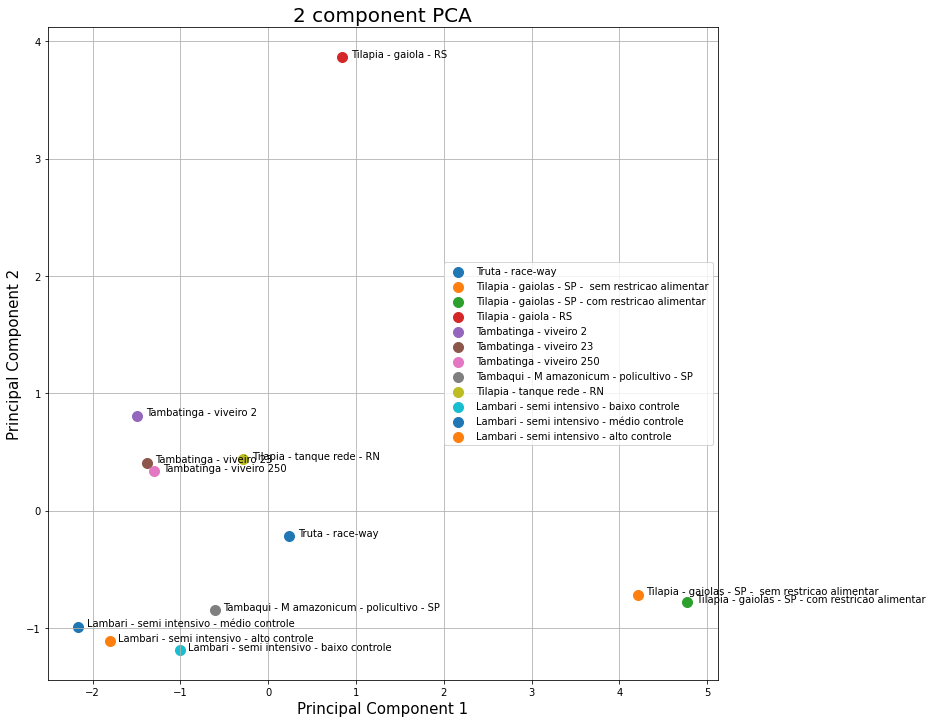

In [18]:
#Visualize results of PCA in Two Dimensions
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = df_cultivo['cultivo'].to_numpy()
print(targets)
for target in targets:
    indicesToKeep = finalDf['cultivo'] == target
    x = finalDf.loc[indicesToKeep, 'principal component 1']
    y = finalDf.loc[indicesToKeep, 'principal component 2']
    ax.scatter(x,y,s = 100)
    ax.annotate(target, (x+0.1,y))

#for name in targets:  
    
ax.legend(targets, loc='center right')
ax.grid()

In [19]:
variance_list =pca.explained_variance_ratio_
print("variance explained by each component:", variance_list)
print("total variance explained:", sum(variance_list))


variance explained by each component: [0.47074243 0.18001895]
total variance explained: 0.650761379060835


In [21]:
#principal components for each indicador
#print(principalComponents)
#print(targets)
df_clustering = pd.DataFrame({'cultivo': targets,  'pc1':list(principalComponents[:,0]), 'pc2': list(principalComponents[:,1])}, columns=['cultivo', 'pc1','pc2'])
#df_clustering

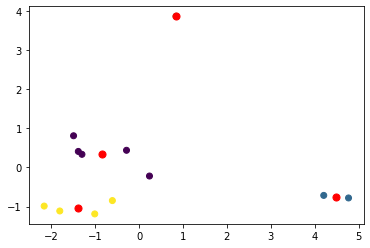

In [22]:
#Find clusters 
from sklearn.cluster import KMeans
#4 clusters
model = KMeans(4)
model.fit(df_clustering.iloc[:,1:3])
#print(model.cluster_centers_)

#Plot clusters
plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50, color="red"); # Show the 

In [23]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')

,cultivo,pc1,pc2,cluster
0,Truta - race-way,0.236314,-0.220377,0
4,Tambatinga - viveiro 2,-1.493231,0.809513,0
5,Tambatinga - viveiro 23,-1.384720,0.408852,0
6,Tambatinga - viveiro 250,-1.302157,0.334816,0
8,Tilapia - tanque rede - RN,-0.287050,0.438120,0
1,Tilapia - gaiolas - SP - sem restricao alimentar,4.206742,-0.715796,1
2,Tilapia - gaiolas - SP - com restricao alimentar,4.771359,-0.781176,1
3,Tilapia - gaiola - RS,0.842281,3.866684,2
7,Tambaqui - M amazonicum - policultivo - SP,-0.608915,-0.848353,3
9,Lambari - semi intensivo - baixo controle,-1.010535,-1.189530,3


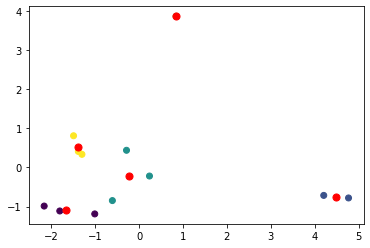

In [24]:
#5 clusters
model = KMeans(5)
model.fit(df_clustering.iloc[:,1:3])
#print(model.cluster_centers_)

#Plot clusters
plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50, color="red"); # Show the 


In my view, we have two large clusters and three outliers, as the graph above shows.

In [25]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')

,cultivo,pc1,pc2,cluster
9,Lambari - semi intensivo - baixo controle,-1.010535,-1.189530,0
10,Lambari - semi intensivo - médio controle,-2.162970,-0.988636,0
11,Lambari - semi intensivo - alto controle,-1.807116,-1.114117,0
1,Tilapia - gaiolas - SP - sem restricao alimentar,4.206742,-0.715796,1
2,Tilapia - gaiolas - SP - com restricao alimentar,4.771359,-0.781176,1
0,Truta - race-way,0.236314,-0.220377,2
7,Tambaqui - M amazonicum - policultivo - SP,-0.608915,-0.848353,2
8,Tilapia - tanque rede - RN,-0.287050,0.438120,2
3,Tilapia - gaiola - RS,0.842281,3.866684,3
4,Tambatinga - viveiro 2,-1.493231,0.809513,4


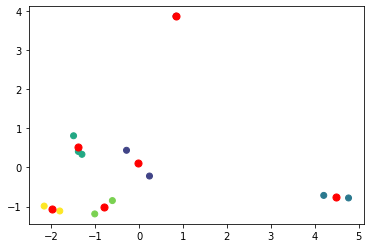

In [26]:
#6 clusters
model = KMeans(6)
model.fit(df_clustering.iloc[:,1:3])
#print(model.cluster_centers_)

#Plot clusters
plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50, color="red"); # Show the 

#7 clusters

In [27]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')

,cultivo,pc1,pc2,cluster
3,Tilapia - gaiola - RS,0.842281,3.866684,0
0,Truta - race-way,0.236314,-0.220377,1
8,Tilapia - tanque rede - RN,-0.287050,0.438120,1
1,Tilapia - gaiolas - SP - sem restricao alimentar,4.206742,-0.715796,2
2,Tilapia - gaiolas - SP - com restricao alimentar,4.771359,-0.781176,2
4,Tambatinga - viveiro 2,-1.493231,0.809513,3
5,Tambatinga - viveiro 23,-1.384720,0.408852,3
6,Tambatinga - viveiro 250,-1.302157,0.334816,3
7,Tambaqui - M amazonicum - policultivo - SP,-0.608915,-0.848353,4
9,Lambari - semi intensivo - baixo controle,-1.010535,-1.189530,4


Now we analyze 3 Principal Components


In [35]:
#Normalize the data to have MEAN==0
from sklearn.preprocessing import StandardScaler

x = df_cultivo.iloc[:,1:].values
x = StandardScaler().fit_transform(x) # normalizing the features
#print(x)

In [36]:
#Run PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
finalDf = pd.concat([principalDf, df_cultivo[['cultivo']]], axis = 1)

In [37]:
variance_list =pca.explained_variance_ratio_
print("variance explained by each component:", variance_list)
print("total variance explained:", sum(variance_list))

variance explained by each component: [0.47074243 0.18001895 0.15247286]
total variance explained: 0.8032342419262226


Now we search for clusters for 3 principal components

In [38]:
#Find clusters 
from sklearn.cluster import KMeans
#4 clusters
model = KMeans(4)
model.fit(df_clustering.iloc[:,1:4])
#print(model.cluster_centers_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [39]:
#principal components for each indicador
#print(principalComponents)
#print(targets)
df_clustering = pd.DataFrame({'cultivo': targets,  'pc1':list(principalComponents[:,0]),
                              'pc2': list(principalComponents[:,1]),'pc3': list(principalComponents[:,2])},
                              columns=['cultivo', 'pc1','pc2','pc3'])
#df_clustering

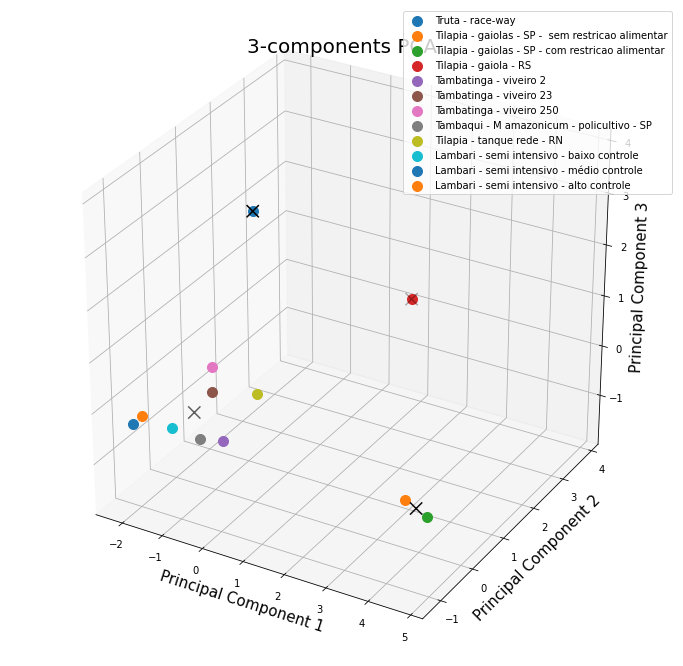

In [40]:
#4 clusters 
from sklearn.cluster import KMeans
model = KMeans(4)
model.fit(df_clustering.iloc[:,1:4])
#print(model.cluster_centers_)

#Plot clusters
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3-components PCA', fontsize = 20)
targets = df_cultivo['cultivo'].to_numpy()

for target in targets:
    indicesToKeep = finalDf['cultivo'] == target
    x = finalDf.loc[indicesToKeep, 'principal component 1']
    y = finalDf.loc[indicesToKeep, 'principal component 2']
    z = finalDf.loc[indicesToKeep, 'principal component 3']
    ax.scatter(x,y,z,s = 100)

ax.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1],model.cluster_centers_[:,2], s=150, marker='x', color="black"); # Show the 
    
ax.legend(targets)
ax.grid()

Now we search for clusters for the 3 principal components

In [41]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')


,cultivo,pc1,pc2,pc3,cluster
4,Tambatinga - viveiro 2,-1.493231,0.809513,-1.610854,0
5,Tambatinga - viveiro 23,-1.384720,0.408852,-0.360660,0
6,Tambatinga - viveiro 250,-1.302157,0.334816,0.204987,0
7,Tambaqui - M amazonicum - policultivo - SP,-0.608915,-0.848353,-0.399732,0
8,Tilapia - tanque rede - RN,-0.287050,0.438120,-0.148557,0
9,Lambari - semi intensivo - baixo controle,-1.010535,-1.189530,-0.073564,0
10,Lambari - semi intensivo - médio controle,-2.162970,-0.988636,-0.392677,0
11,Lambari - semi intensivo - alto controle,-1.807116,-1.114117,-0.072908,0
1,Tilapia - gaiolas - SP - sem restricao alimentar,4.206742,-0.715796,-0.469242,1
2,Tilapia - gaiolas - SP - com restricao alimentar,4.771359,-0.781176,-0.634728,1


Comparing k-means of PC12 with PC123, we see that the cluster membership changes completely.

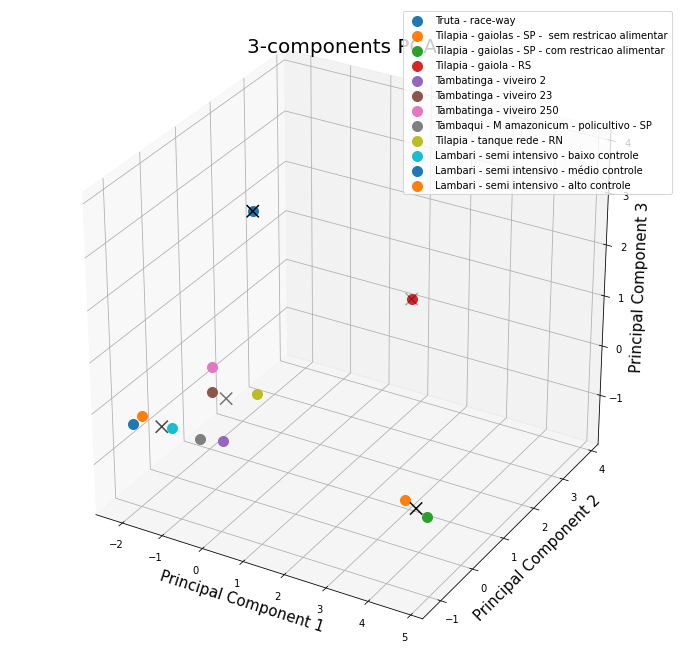

In [42]:
#5 clusters 
from sklearn.cluster import KMeans
model = KMeans(5)
model.fit(df_clustering.iloc[:,1:4])
#print(model.cluster_centers_)

#Plot clusters
#plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
#plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50, color="red"); # Show the 

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3-components PCA', fontsize = 20)
targets = df_cultivo['cultivo'].to_numpy()

for target in targets:
    indicesToKeep = finalDf['cultivo'] == target
    x = finalDf.loc[indicesToKeep, 'principal component 1']
    y = finalDf.loc[indicesToKeep, 'principal component 2']
    z = finalDf.loc[indicesToKeep, 'principal component 3']
    ax.scatter(x,y,z,s = 100)
    #ax.annotate(target, (x,y))

ax.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1],model.cluster_centers_[:,2], s=150, marker='x', color="black"); # Show the 

#for name in targets:  
    
ax.legend(targets)
ax.grid()

In [43]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')

,cultivo,pc1,pc2,pc3,cluster
7,Tambaqui - M amazonicum - policultivo - SP,-0.608915,-0.848353,-0.399732,0
9,Lambari - semi intensivo - baixo controle,-1.010535,-1.189530,-0.073564,0
10,Lambari - semi intensivo - médio controle,-2.162970,-0.988636,-0.392677,0
11,Lambari - semi intensivo - alto controle,-1.807116,-1.114117,-0.072908,0
1,Tilapia - gaiolas - SP - sem restricao alimentar,4.206742,-0.715796,-0.469242,1
2,Tilapia - gaiolas - SP - com restricao alimentar,4.771359,-0.781176,-0.634728,1
3,Tilapia - gaiola - RS,0.842281,3.866684,0.144939,2
0,Truta - race-way,0.236314,-0.220377,3.812997,3
4,Tambatinga - viveiro 2,-1.493231,0.809513,-1.610854,4
5,Tambatinga - viveiro 23,-1.384720,0.408852,-0.360660,4


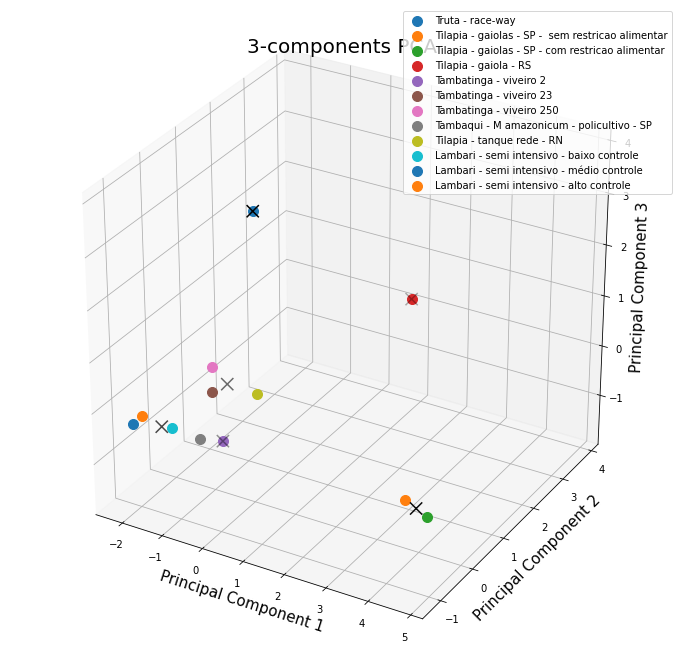

In [44]:
#6 clusters 
from sklearn.cluster import KMeans
model = KMeans(6)
model.fit(df_clustering.iloc[:,1:4])
#print(model.cluster_centers_)

#Plot clusters
#plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
#plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50, color="red"); # Show the 

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3-components PCA', fontsize = 20)
targets = df_cultivo['cultivo'].to_numpy()

for target in targets:
    indicesToKeep = finalDf['cultivo'] == target
    x = finalDf.loc[indicesToKeep, 'principal component 1']
    y = finalDf.loc[indicesToKeep, 'principal component 2']
    z = finalDf.loc[indicesToKeep, 'principal component 3']
    ax.scatter(x,y,z,s = 100)
    #ax.annotate(target, (x,y))

ax.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1],model.cluster_centers_[:,2], s=150, marker='x', color="black"); # Show the 

#for name in targets:  
    
ax.legend(targets)
ax.grid()

In [45]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')

,cultivo,pc1,pc2,pc3,cluster
5,Tambatinga - viveiro 23,-1.384720,0.408852,-0.360660,0
6,Tambatinga - viveiro 250,-1.302157,0.334816,0.204987,0
8,Tilapia - tanque rede - RN,-0.287050,0.438120,-0.148557,0
1,Tilapia - gaiolas - SP - sem restricao alimentar,4.206742,-0.715796,-0.469242,1
2,Tilapia - gaiolas - SP - com restricao alimentar,4.771359,-0.781176,-0.634728,1
0,Truta - race-way,0.236314,-0.220377,3.812997,2
3,Tilapia - gaiola - RS,0.842281,3.866684,0.144939,3
7,Tambaqui - M amazonicum - policultivo - SP,-0.608915,-0.848353,-0.399732,4
9,Lambari - semi intensivo - baixo controle,-1.010535,-1.189530,-0.073564,4
10,Lambari - semi intensivo - médio controle,-2.162970,-0.988636,-0.392677,4
